In [2]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path

realigned_atlas = nib.load('../../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 

# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../../Data/pig_2/rfmri files/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)
        
assert all_data.shape == (300, 128, 128, 20)
assert masked_data.shape == (300, 128, 128, 20)# basic sanity check

indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]


In [3]:
from keras.models import load_model
m = load_model('e11_model.h5')

m.evaluate(data_block[:1000], data_block[:1000])

 992/1000 [============================>.] - ETA: 0s

8338.5980117187501

In [4]:
layer_14 = m.layers[14]
layer_14.get_config()

{'name': 'max_pooling1d_115',
 'padding': 'valid',
 'pool_size': (3,),
 'strides': (3,),
 'trainable': True}

In [5]:
from sklearn import manifold
from time import time

embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
embeddings = embedding_model.predict(data_block)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(embeddings.shape)
print(squished_embeddings.shape)

(7155, 25, 8)
(7155, 200)


FileNotFoundError: [Errno 2] No such file or directory: '../../Results/tsne_e11/tsne_100_pig_2_full_dataset.png'

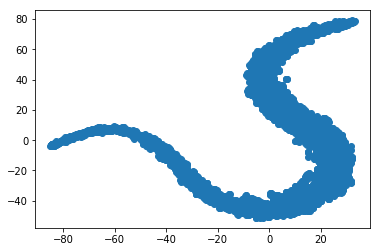

In [8]:
tsne_100 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=100)
tsne_100_result = tsne_100.fit_transform(squished_embeddings)
plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1])
plt.savefig('../../Results/tsne_e11/tsne_100_pig_2_full_dataset.png')
np.save('../../Data/numpy-data/e11_tsne_100_pig_2_full_dataset.npy', tsne_100_result) 
